In [35]:
import json
import requests
import datetime as datetime 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [36]:
start_date = datetime.datetime.now().strftime("%Y-%m-%d") #current day and month
end_date = (datetime.datetime.now() + datetime.timedelta(7)).strftime("%Y-%m-%d") #30 days ahead

In [37]:
response = requests.get('https://api.stocktwits.com/api/2/discover/earnings_calendar?date_from='+start_date+'&date_to='+end_date)
data = response.json()['earnings']

In [38]:
w = []

for i in range(1,8):
    try:
        for b in data[(datetime.datetime.now() + datetime.timedelta(i)).strftime("%Y-%m-%d")]['stocks']:
            w.append(b)
    except:
        pass

In [39]:
ww = pd.DataFrame(w)
spa = ww[ww.importance == 5][['date','symbol','title']]
spa

,date,symbol,title
0,2018-01-16,C,Citigroup
5,2018-01-16,CMA,Comerica
12,2018-01-17,BAC,Bank of America
13,2018-01-17,GS,Goldman Sachs Group
48,2018-01-18,IBM,IBM
52,2018-01-18,MS,Morgan Stanley
120,2018-01-19,GE,General Electric


In [40]:
import quandl

with open('quandl.txt') as f:
    key = f.read()

GG = pd.DataFrame()

for sym in spa.symbol:
    GG[sym] = quandl.get("WIKI/"+sym, start_date='2017-01-01',authtoken=key)['Adj. Close']

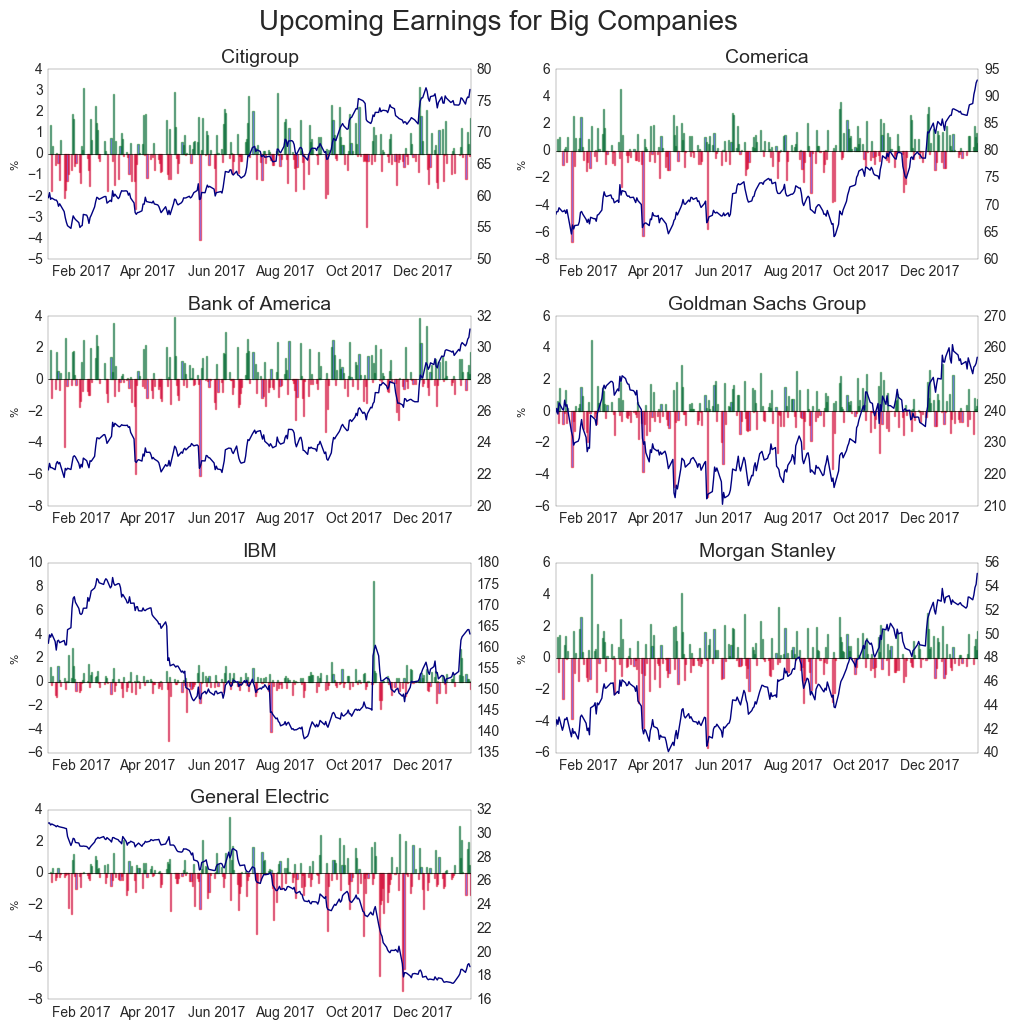

In [44]:
GG.columns = spa.title

plt.figure(figsize=(12,12))
plt.suptitle('Upcoming Earnings for Big Companies',y=0.95,fontsize=20)
plt.style.use('seaborn-white')
plt.rcParams['axes.linewidth'] = 0.1

N = 1

for p in GG:

    ax = plt.subplot(round((len(GG.T)/2)+1),2,N)
        
    Logreturn = (np.log(GG[p]/GG[p].shift(1))*100).dropna()
    colors = []

    for i in range(0,len(Logreturn)):
        if Logreturn[i] >= 0:
            colors.append('green')
        if Logreturn[i] < 0:
            colors.append('Red')
    
    plt.subplots_adjust(hspace=0.3, wspace = 0.2)        
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title(p,fontsize=14)

    ax.bar(Logreturn.index, Logreturn, width=1, label='Returns',edgecolor=colors,alpha=0.5)
    ax.axhline(0,color='k',lw=0.5)# barchart
    plt.tick_params(axis='both', which='major', labelsize=10)
    ax2 = ax.twinx()
    plt.tick_params(axis='both', which='major', labelsize=10)
    ax2.plot(GG[p],lw=1.5,color='navy',linewidth=1) 
    ax.set_ylabel("%",fontsize='small')
    plt.grid(False)
    N+=1

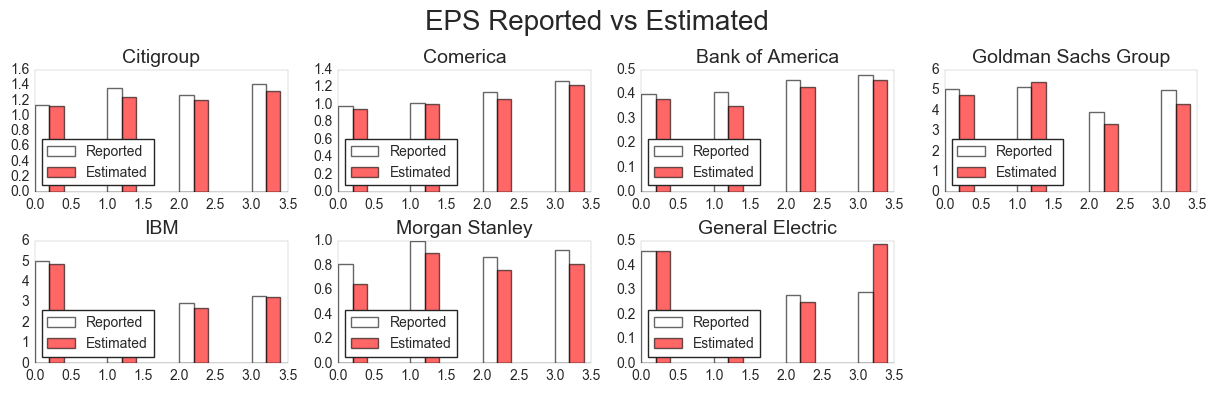

In [48]:
import time

i = 1

plt.figure(figsize=(15,6))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.style.use('seaborn-white')
plt.suptitle("EPS Reported vs Estimated", fontsize=20,y=1)
plt.rcParams['axes.linewidth'] = 0.1

for t in spa.symbol:
    df = pd.read_html(requests.get('https://www.barchart.com/stocks/quotes/'+str(t)+'/earnings-estimates',headers={'User-agent': 'Mozilla/5.0'}).text)
    hd = df[0]
    hd.columns = ['Earnings History','4','3','2','1']
    hd.index = hd['Earnings History']
    del hd['Earnings History']
    hd = pd.DataFrame(hd.T)
    hd['Reported'] = hd['Reported'].str.replace('$','')
    hd['Estimate'] = hd['Estimate'].str.replace('$','')
    hd['Reported'] = hd['Reported'].convert_objects(convert_numeric=True)
    hd['Estimate'] = hd['Estimate'].convert_objects(convert_numeric=True)
    TTT = hd.iloc[::-1]
    TTTT = TTT[['Reported','Estimate']]
    
    plt.subplot(round((len(GG.T)/4)+1),4,i)
    
    plt.bar(np.arange(len(TTTT.index)), TTTT.Reported,width=0.2,color='white',edgecolor='black',label='Reported',alpha=0.6)
    plt.bar(np.arange(len(TTTT.index))+0.2,TTTT.Estimate,width=0.2,color='red',edgecolor='black',label='Estimated',alpha=0.6)
    plt.title(GG.columns[i-1],fontsize=14)
    
    plt.legend(loc=3,fontsize='medium',frameon=1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.2) 
    plt.grid(False)
    plt.axhline(0,ls='-',c='black',alpha=0.6)
    i+=1

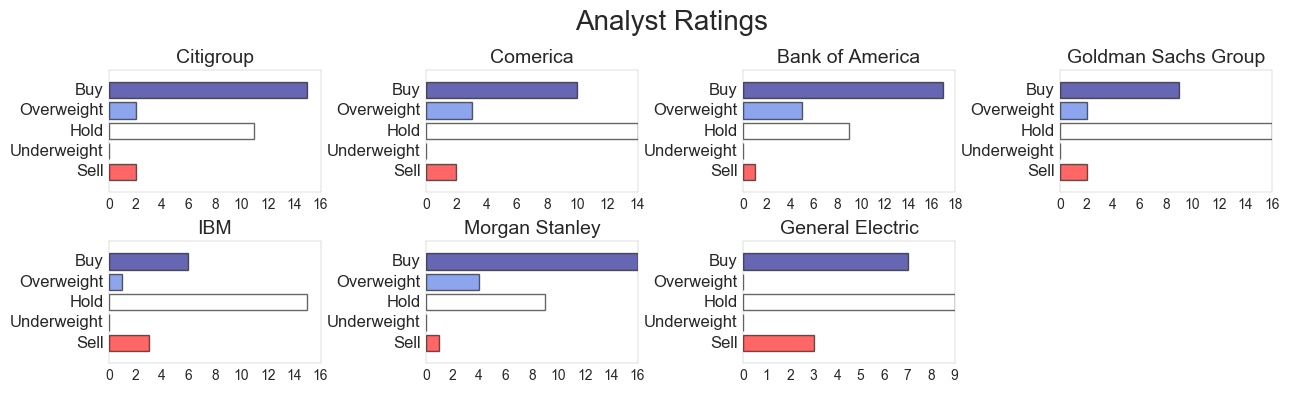

In [49]:
plt.figure(figsize=(15,6))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.style.use('seaborn-white')
plt.suptitle("Analyst Ratings", fontsize=20,y=1)
plt.rcParams['axes.linewidth'] = 0.1

i = 1

for t in spa.symbol:
    
    try:
        hd = pd.read_html(requests.get('http://www.barrons.com/quote/stock/us/xnys/'+str(t)+'/research-ratings',headers={'User-agent': 'Mozilla/5.0'}).text)
    except:
        try:
            hd = pd.read_html(requests.get('http://www.barrons.com/quote/stock/us/xnas/'+str(t)+'/research-ratings',headers={'User-agent': 'Mozilla/5.0'}).text)
        except:
            pass
        
    t = hd[1][1:6]
    t.columns = ['Recom','3M Ago','1M Ago','Current']
    tt = t[['Recom','Current']]
    tt.index = tt.Recom
    del tt['Recom']
    tt['Current'] = tt.Current.convert_objects(convert_numeric=True).values

    plt.subplot(round((len(GG.T)/4)+1),4,i)
    plt.barh(np.arange(len(tt.index)),tt.Current,align='center',color=['navy','royalblue','white','salmon','red'],
                                                                  edgecolor='black',alpha=0.6)
    plt.gca().invert_yaxis() # labels read top-to-bottom
    plt.yticks(np.arange(len(tt.index)),['Buy','Overweight','Hold','Underweight','Sell'],fontsize=12)
    plt.title(GG.columns[i-1],fontsize=14)
    plt.subplots_adjust(hspace=0.4, wspace = 0.5)
    plt.grid(False)
    time.sleep(1)
    i+=1

In [88]:
FINAL = spa
FINAL.index = FINAL.date
FINAL.index.name = ''
FINAL = FINAL[['symbol','title']]
FINAL.columns = ['Symbol','Upcoming Major Earnings']

In [91]:
from IPython.display import display, HTML

FINAL

HTML('''
        <style>
            .FINAL thead {background-color: navy;}
            .FINAL thead {color: white;}
            .FINAL tbody tr:nth-child(even) { background-color: white; }
            .FINAL tbody tr:nth-child(odd) { background-color: white; }
            .FINAL th { text-align: center; }
            
            table.FINAL, .FINAL th, .FINAL td{
              border: none;
              border-bottom: 1px solid #C8C8C8;
              border-collapse: collapse;
              text-align:center;
              padding: 4px;
              margin-bottom: 0px;
              font-size: 0.9em;}
        </style>
    
 
        ''' + FINAL.to_html(classes="FINAL"))

,Symbol,Upcoming Major Earnings
,,
2018-01-16,C,Citigroup
2018-01-16,CMA,Comerica
2018-01-17,BAC,Bank of America
2018-01-17,GS,Goldman Sachs Group
2018-01-18,IBM,IBM
2018-01-18,MS,Morgan Stanley
2018-01-19,GE,General Electric
